## Loading Dependencies

In [28]:
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import numpy as np
import Levenshtein
from fuzzywuzzy import fuzz
import re
from nltk.corpus import stopwords
import distance
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from tqdm.notebook import tqdm
tqdm.pandas()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/subham/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /Users/subham/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [1]:
os.chdir('/Users/subham/Downloads')

## Reading Data

In [3]:
xls = pd.ExcelFile('mappinghotelsdataset.xlsx')

In [4]:
xls.sheet_names

['Partner1', 'Partner2', 'examples']

In [6]:
partner1_data = pd.read_excel('mappinghotelsdataset.xlsx', sheet_name="Partner1")
partner2_data = pd.read_excel('mappinghotelsdataset.xlsx', sheet_name="Partner2")
example_data = pd.read_excel('mappinghotelsdataset.xlsx', sheet_name="examples")

In [22]:
partner1_data.sample(5)

,key,hotel_name,city_name,country_code,hotel_address,star_rating,postal_code
3621,FFE5ED550FDD4BD449B78E5ADCA208F2,Hotel Montsouris Orleans,Paris,FR,"15, rue Beaunier",3.0,75014
17,F8685C659AF9347E0B1CF5C7FF2959AF,La Flora Pavanputra Resort & Spa - Hassan,Hassan,IN,"Flat No. 114, 116, 117, Rangoli Halla, KIADB I...",3.0,573201
3758,EC6B083EE9CC8C22CDA2AE1EF110D3EB,Golden Bauhinia International Hotel Nanning,Nanning,CN,"No.6,Changhu Road,Qingxiu District",5.0,530023
9311,ADFA123F3B41EDA3C43254F1E0F3DC1F,Volivia Relais Hotel,Pegognaga,IT,21 Vo Street,0.0,46020
2683,DE2126A9B990548C1C93F5DE4F8BC640,Best Western Golf Hotel Colvert,Levernois,FR,Rue du Golf,4.0,21200


## Renaming Columns for convenience

In [21]:
partner1_data = partner1_data.rename(columns = {'p1.key':'key' , 'p1.hotel_name':'hotel_name','p1.city_name':'city_name',
                               'p1.country_code':'country_code','p1.hotel_address':'hotel_address',
                               'p1.star_rating':'star_rating','p1.postal_code':'postal_code'})

In [19]:
partner2_data = partner2_data.rename(columns = {'p2.key':'key' , 'p2.hotel_name':'hotel_name','p2.city_name':'city_name',
                               'p2.country_code':'country_code','p2.hotel_address':'hotel_address',
                               'p2.star_rating':'star_rating','p2.postal_code':'postal_code'})

In [37]:
partner1_data.shape,partner2_data.shape

((10000, 7), (10000, 7))

In [11]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

## Exploring common words - which we will remove so that I can perform first set of matches based on similar proper names

In [42]:
combine_df = pd.concat([partner1_data[['hotel_name']],partner2_data[['hotel_name']]])
top_N = 50
a = combine_df['hotel_name'].str.lower().str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(a)
total_words = len(set(words))
word_dist = nltk.FreqDist(words)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                   columns = ['Word','Frequency'])
rslt['common_percentage'] = rslt['Frequency']*100/total_words
#rslt = rslt[rslt['Frequency']>1000]


In [43]:
rslt

,Word,Frequency,common_percentage
0,hotel,7628,67.165625
1,inn,2492,21.942414
2,resort,1387,12.212732
3,&,1002,8.822752
4,the,1002,8.822752
5,suites,819,7.211411
6,house,785,6.912037
7,villa,686,6.040328
8,-,612,5.388747
9,and,592,5.212644


In [44]:
STOP_WORDS = ['hotel','inn','resort','a','&','and','the','of','apartments','villa','villas','suites','house','lodge','hostel',
             'boutique','motel','spa','guesthouse','station','plaza','palace','airport',]

## Text Preprocessing  - Hotel names

In [51]:
def text_preprocessor(df):
    cleaned = []
    for titles in tqdm(df['hotel_name']):
        title = str(titles).lower()
        title = title.strip()
        title = title.replace('\\r',' ')
        title = title.replace('\\"',' ')
        title = title.replace('\\n',' ')
        title = title.replace("'s",'')
        title = re.sub('[^A-Za-z0-9]+',' ',title)
        title = re.sub('[0-9]+',' ',title)
        title = ' '.join(f for f in title.split() if f not in STOP_WORDS)
        cleaned.append(title.strip())
    return cleaned
        
        

In [52]:
cleaned_p1 = text_preprocessor(partner1_data)
cleaned_p2 = text_preprocessor(partner2_data)

In [54]:
partner1_data.rename(columns={'hotel_name':'unclean_hotel_name'},inplace=True)
partner2_data.rename(columns={'hotel_name':'unclean_hotel_name'},inplace=True)

partner1_data['hotel_name'] = cleaned_p1
partner2_data['hotel_name'] = cleaned_p2

partner1_data.reset_index(inplace=True)
partner2_data.reset_index(inplace=True)

partner1_data.drop('index',axis=1,inplace=True)
partner2_data.drop('index',axis=1,inplace=True)


In [56]:
partner1_data.head(2)

,key,unclean_hotel_name,city_name,country_code,hotel_address,star_rating,postal_code,hotel_name
0,5E876BFEA81A39E42E3019FE17303D52,Elite Grande Hotel,Manama,BH,"Bldg 3378, Road 2845, Area 428",4.0,5458,elite grande
1,4F315989358CC0F3F7869F569887743D,Quality Inn West Chester,West Chester (OH),US,8567 Cincinnati Dayton Road,3.0,45069,quality west chester


## STEP 1 Modelling : For narrowing the search space

In [66]:
p1_keys_list = []
p2_keys_list = []
p1_hotel_names_list = []
p2_hotel_names_list = []
p1_unclean_hotel_names_list = []
p2_unclean_hotel_names_list = []
p1_city_names_list = []
p2_city_names_list = []
p1_country_codes_list = []
p2_country_codes_list = []
step1_scores_list = []
total_matches_found= []
def first_batch_best_match(df):
    p1_key = df['key']
    p1_hotel_name = df['hotel_name']
    p1_unclean_hotel_name = df['unclean_hotel_name']
    p1_city_name = df['city_name']
    p1_country_code = df['country_code']
    
    #As mentioned matches should be from same country
    p2_country_wise = partner2_data[partner2_data['country_code'] == p1_country_code]
    
    #since i have removed common words in STEP 1 , so i am going for partial ratio so that i can have
    # a mapping for all strings having the proper noun of hotel names
    score_list = []
    for p2_hotel_name in list(p2_country_wise['hotel_name']):
        score_list.append(fuzz.partial_ratio(p1_hotel_name,p2_hotel_name))
    p2_country_wise['step1_fuzzy_scores'] =  score_list 
    p2_country_wise = p2_country_wise.sort_values('step1_fuzzy_scores',ascending = False)
    
    '''If we have more than 10 records , pick the 10th element score and use it as a thresold
    This method solves problems due to matches with same scores and we might miss a match if we take top n'''
    if len(p2_country_wise)>=10:
        gt_10_threshold = p2_country_wise['step1_fuzzy_scores'].iloc[9]
        p2_country_wise = p2_country_wise[p2_country_wise['step1_fuzzy_scores']>=gt_10_threshold]
    
    
    p2_keys = list(p2_country_wise['key'])
    p2_hotel_names = list(p2_country_wise['hotel_name'])
    p2_unclean_hotel_names = list(p2_country_wise['unclean_hotel_name'])
    p2_city_names = list(p2_country_wise['city_name'])
    p2_country_codes = list(p2_country_wise['country_code'])
    scores = list(p2_country_wise['step1_fuzzy_scores'])
    
    '''Preparing lists for creating Dataframe'''
    p1_keys_list.append(p1_key)
    p1_hotel_names_list.append(p1_hotel_name)
    p1_unclean_hotel_names_list.append(p1_unclean_hotel_name)
    p1_city_names_list.append(p1_city_name)
    p1_country_codes_list.append(p1_country_code)
    
    p2_keys_list.append(p2_keys)
    p2_hotel_names_list.append(p2_hotel_names)
    p2_unclean_hotel_names_list.append(p2_unclean_hotel_names)
    p2_city_names_list.append(p2_city_names)
    p2_country_codes_list.append(p2_country_codes)
    
    step1_scores_list.append(scores)
    total_matches_found.append(len(p2_hotel_names))

In [67]:
ans = partner1_data.progress_apply(first_batch_best_match,axis=1)

In [68]:
results = pd.DataFrame()
results['p1_key'] = p1_keys_list
results['p1_hotel_name'] = p1_hotel_names_list
results['p1_unclean_hotel_name'] = p1_unclean_hotel_names_list
results['p1_city_name'] = p1_city_names_list
results['p1_country_code'] = p1_country_codes_list

results['p2_key'] = p2_keys_list
results['p2_hotel_name'] = p2_hotel_names_list
results['p2_unclean_hotel_name'] = p2_unclean_hotel_names_list
results['p2_city_name'] = p2_city_names_list
results['p2_country_code'] = p2_country_codes_list

results['step1_fuzzy_score'] = step1_scores_list
results['step1_total_matches'] = total_matches_found

In [69]:
results.to_csv('step1_results.csv',index=False)


In [76]:
results.head()

,p1_key,p1_hotel_name,query_str,p1_city_name,p1_country_code,p2_key,p2_hotel_name,search_list,p2_city_name,p2_country_code,step1_fuzzy_score,step1_total_matches
0,5E876BFEA81A39E42E3019FE17303D52,elite grande,Elite Grande Hotel,Manama,BH,"[A70AE7B9AC32D7CB1B268A1900E46857, D1B48E98D68...","[elite, elite grande, ritz carlton bahrain, tu...","[Elite Resort & Spa, Elite Grande, The Ritz-Ca...","[Manama, Manama, Manama, Manama, Manama, Manam...","[BH, BH, BH, BH, BH, BH, BH, BH, BH, BH, BH, BH]","[100, 100, 50, 50, 50, 50, 42, 42, 35, 33, 33,...",12
1,4F315989358CC0F3F7869F569887743D,quality west chester,Quality Inn West Chester,West Chester (OH),US,"[8D845A8DAFAE068BFD7E4B638BDE0D7B, B301718653A...","[quality, quality, quality west chester, quali...","[Quality Inn & Suites, Quality Inn, Quality In...","[Plainview, Hillsboro, West Chester, Lake Char...","[US, US, US, US, US, US, US, US, US, US, US]","[100, 100, 100, 100, 100, 82, 78, 78, 77, 75, 75]",11
2,A4EEBCBB9932DADE591248DFFFBDC068,map village,MAP5 Village Resort,Goa,IN,"[1A83AC6BA04BA9A8A080888637331359, 4A3B1503143...","[map village, vaayu waterman village, punarnav...","[MAP5 Village Resort, Vaayu Waterman's Village...","[Morjim, Mandrem, Cochin, Morjim, Gādigarpālya...","[IN, IN, IN, IN, IN, IN, IN, IN, IN, IN, IN]","[100, 91, 82, 73, 73, 67, 67, 67, 67, 64, 64]",11
3,2833BE9FD49A063A36D3DE1E5E28ABC4,hampton san jose,Hampton Inn & Suites San Jose Hotel,San Jose (CA),US,"[3F2A136272AB1BC4EE09E0695BECFFD1, 10F28D15260...","[hampton san jose, m, four points by sheraton ...","[Hampton Inn & Suites San Jose, M Boutique Hot...","[San Jose, Miami Beach, San Jose, San Angelo, ...","[US, US, US, US, US, US, US, US, US, US, US, U...","[100, 100, 88, 81, 75, 75, 71, 71, 69, 69, 69,...",29
4,F7C20B50AE5C6C807BAABB65B8926F07,favehotel daeng tompo,Favehotel Daeng Tompo,Makassar,ID,"[F47B75C6C93D75F5B83E721AF7561E4B, 8D801E7A3C3...","[favehotel daeng tompo, elhotel malang, de dau...","[favehotel Daeng Tompo, ElHotel Malang, Villa ...","[Makassar, Dau, Legian, Semarang, Seminyak, Se...","[ID, ID, ID, ID, ID, ID, ID, ID, ID, ID]","[100, 71, 71, 70, 67, 67, 67, 62, 60, 60]",10


## STEP 2: 
1 . Searching on selected/limited search space and getting top match
2. Will be using Unclean hotel names for matching now.

In [71]:
results = results.rename(columns = {'p1_unclean_hotel_name':'query_str', 'p2_unclean_hotel_name':'search_list'})

In [72]:
backup = results

In [160]:
def second_batch_best_match(query_str,search_list,p2_key_list,p2_country_code_list,p2_city_name_list):
    matched_p2_key = []
    matched_p2_unclean_hotel_name = []
    matched_p2_country_code = []
    matched_p2_city_name = []
    score_lists = []
    
    query_str = [query_str]
    '''Creating tuples for string comparison'''
    string_tuples = [(query_str[0],search_list[i]) for i in range(0,len(search_list))]
    
    '''Calculating Levenshtein Distance'''
    resultant = []
    for s1,s2 in string_tuples:
        resultant.append(Levenshtein.distance(s1,s2))
    '''Performing indexing to get the best possible match in first place'''
    resultant_dict = dict(zip(range(len(resultant)),resultant))
    resultant_dict_thresholded = {key:val for key,val in resultant_dict.items() if val<20}
    resultant_dict_thresholded_sorted = dict(sorted(resultant_dict_thresholded.items(),key = lambda x:x[1],reverse=False))


    
    '''Fetching the scores,ids,matches etc'''
    if len(list(resultant_dict_thresholded_sorted.keys()))>0:
        indices = list(resultant_dict_thresholded_sorted.keys())[0]#first one is the best match
        indices = [indices]
        scores = list(resultant_dict_thresholded_sorted.values())[0]#first one is the best match
        scores = [scores]
    
        matched_p2_key.append(p2_key_list[indices[0]])
        matched_p2_unclean_hotel_name.append(search_list[indices[0]])
        matched_p2_country_code.append(p2_country_code_list[indices[0]])
        matched_p2_city_name.append(p2_city_name_list[indices[0]])
        score_lists.append(scores[0])
        
    else:
        matched_p2_key.append('Match Not Found')
        matched_p2_unclean_hotel_name.append('Match Not Found')
        matched_p2_country_code.append('Match Not Found')
        matched_p2_city_name.append('Match Not Found')
        score_lists.append('Match Not Found')

    
    sorted_res = []
    for p2_key, hotel_name, country_cd, city_nm , score in zip(matched_p2_key,matched_p2_unclean_hotel_name,matched_p2_country_code,matched_p2_city_name,score_lists):
        sorted_res.append((p2_key, hotel_name, country_cd, city_nm, score))
    return sorted_res

In [161]:
results['step2_fuzzy_score_and_matches'] = results.progress_apply(lambda x: second_batch_best_match(x['query_str'],
                                                                                        x['search_list'],
                                                                                        x['p2_key'],
                                                                                        x['p2_country_code'],
                                                                                        x['p2_city_name'])
                                                     ,axis=1)

In [163]:
results.head()

,p1_key,p1_hotel_name,query_str,p1_city_name,p1_country_code,p2_key,p2_hotel_name,search_list,p2_city_name,p2_country_code,step1_fuzzy_score,step1_total_matches,step2_fuzzy_score,step2_fuzzy_score_and_matches,score
0,5E876BFEA81A39E42E3019FE17303D52,elite grande,Elite Grande Hotel,Manama,BH,"[A70AE7B9AC32D7CB1B268A1900E46857, D1B48E98D68...","[elite, elite grande, ritz carlton bahrain, tu...","[Elite Resort & Spa, Elite Grande, The Ritz-Ca...","[Manama, Manama, Manama, Manama, Manama, Manam...","[BH, BH, BH, BH, BH, BH, BH, BH, BH, BH, BH, BH]","[100, 100, 50, 50, 50, 50, 42, 42, 35, 33, 33,...",12,"[(D1B48E98D68672E4EB9B8A8B06799EDE, Elite Gran...","[(D1B48E98D68672E4EB9B8A8B06799EDE, Elite Gran...",[6]
1,4F315989358CC0F3F7869F569887743D,quality west chester,Quality Inn West Chester,West Chester (OH),US,"[8D845A8DAFAE068BFD7E4B638BDE0D7B, B301718653A...","[quality, quality, quality west chester, quali...","[Quality Inn & Suites, Quality Inn, Quality In...","[Plainview, Hillsboro, West Chester, Lake Char...","[US, US, US, US, US, US, US, US, US, US, US]","[100, 100, 100, 100, 100, 82, 78, 78, 77, 75, 75]",11,"[(28E50B8F4185B367F6B31F9B2151D634, Quality In...","[(28E50B8F4185B367F6B31F9B2151D634, Quality In...",[0]
2,A4EEBCBB9932DADE591248DFFFBDC068,map village,MAP5 Village Resort,Goa,IN,"[1A83AC6BA04BA9A8A080888637331359, 4A3B1503143...","[map village, vaayu waterman village, punarnav...","[MAP5 Village Resort, Vaayu Waterman's Village...","[Morjim, Mandrem, Cochin, Morjim, Gādigarpālya...","[IN, IN, IN, IN, IN, IN, IN, IN, IN, IN, IN]","[100, 91, 82, 73, 73, 67, 67, 67, 67, 64, 64]",11,"[(1A83AC6BA04BA9A8A080888637331359, MAP5 Villa...","[(1A83AC6BA04BA9A8A080888637331359, MAP5 Villa...",[0]
3,2833BE9FD49A063A36D3DE1E5E28ABC4,hampton san jose,Hampton Inn & Suites San Jose Hotel,San Jose (CA),US,"[3F2A136272AB1BC4EE09E0695BECFFD1, 10F28D15260...","[hampton san jose, m, four points by sheraton ...","[Hampton Inn & Suites San Jose, M Boutique Hot...","[San Jose, Miami Beach, San Jose, San Angelo, ...","[US, US, US, US, US, US, US, US, US, US, US, U...","[100, 100, 88, 81, 75, 75, 71, 71, 69, 69, 69,...",29,"[(3F2A136272AB1BC4EE09E0695BECFFD1, Hampton In...","[(3F2A136272AB1BC4EE09E0695BECFFD1, Hampton In...",[6]
4,F7C20B50AE5C6C807BAABB65B8926F07,favehotel daeng tompo,Favehotel Daeng Tompo,Makassar,ID,"[F47B75C6C93D75F5B83E721AF7561E4B, 8D801E7A3C3...","[favehotel daeng tompo, elhotel malang, de dau...","[favehotel Daeng Tompo, ElHotel Malang, Villa ...","[Makassar, Dau, Legian, Semarang, Seminyak, Se...","[ID, ID, ID, ID, ID, ID, ID, ID, ID, ID]","[100, 71, 71, 70, 67, 67, 67, 62, 60, 60]",10,"[(F47B75C6C93D75F5B83E721AF7561E4B, favehotel ...","[(F47B75C6C93D75F5B83E721AF7561E4B, favehotel ...",[1]


## SUMMARISING

In [164]:
p1_keys_list = []
p1_hotel_name_list = []
p1_country_cd_list = []
p1_city_nm_list = []

p2_keys_list = []
p2_hotel_name_list = []
p2_country_cd_list = []
p2_city_nm_list = []
p2_score_list = []
def summary_writer(df):
    p1_key = df['p1_key']
    p1_hotel_name = df['query_str']
    p1_city_name = df['p1_city_name']
    p1_country_code = df['p1_country_code']
    
    p1_keys_list.append(p1_key)
    p1_hotel_name_list.append(p1_hotel_name)
    p1_country_cd_list.append(p1_country_code)
    p1_city_nm_list.append(p1_city_name)
    
    row = df['step2_fuzzy_score_and_matches']
    for t in row:
        p2_keys_list.append(t[0])
        p2_hotel_name_list.append(t[1])
        p2_country_cd_list.append(t[2])
        p2_city_nm_list.append(t[3])
        p2_score_list.append(t[4])

In [165]:
ans = results.progress_apply(summary_writer,axis=1)

In [166]:
summary_df = pd.DataFrame()
summary_df['p1_key'] = p1_keys_list
summary_df['p1_hotel_name'] = p1_hotel_name_list
summary_df['p1_city_name'] = p1_city_nm_list
summary_df['p1_country_code'] = p1_country_cd_list

summary_df['p2_key'] = p2_keys_list
summary_df['p2_hotel_name'] = p2_hotel_name_list
summary_df['p2_city_name'] = p2_city_nm_list
summary_df['p2_country_code'] = p2_country_cd_list

summary_df['score'] = p2_score_list


In [167]:
summary_df.head()

,p1_key,p1_hotel_name,p1_city_name,p1_country_code,p2_key,p2_hotel_name,p2_city_name,p2_country_code,score
0,5E876BFEA81A39E42E3019FE17303D52,Elite Grande Hotel,Manama,BH,D1B48E98D68672E4EB9B8A8B06799EDE,Elite Grande,Manama,BH,6
1,4F315989358CC0F3F7869F569887743D,Quality Inn West Chester,West Chester (OH),US,28E50B8F4185B367F6B31F9B2151D634,Quality Inn West Chester,West Chester,US,0
2,A4EEBCBB9932DADE591248DFFFBDC068,MAP5 Village Resort,Goa,IN,1A83AC6BA04BA9A8A080888637331359,MAP5 Village Resort,Morjim,IN,0
3,2833BE9FD49A063A36D3DE1E5E28ABC4,Hampton Inn & Suites San Jose Hotel,San Jose (CA),US,3F2A136272AB1BC4EE09E0695BECFFD1,Hampton Inn & Suites San Jose,San Jose,US,6
4,F7C20B50AE5C6C807BAABB65B8926F07,Favehotel Daeng Tompo,Makassar,ID,F47B75C6C93D75F5B83E721AF7561E4B,favehotel Daeng Tompo,Makassar,ID,1


In [168]:
summary_df.shape

(10000, 9)

In [169]:
summary_df.head(30)

,p1_key,p1_hotel_name,p1_city_name,p1_country_code,p2_key,p2_hotel_name,p2_city_name,p2_country_code,score
0,5E876BFEA81A39E42E3019FE17303D52,Elite Grande Hotel,Manama,BH,D1B48E98D68672E4EB9B8A8B06799EDE,Elite Grande,Manama,BH,6
1,4F315989358CC0F3F7869F569887743D,Quality Inn West Chester,West Chester (OH),US,28E50B8F4185B367F6B31F9B2151D634,Quality Inn West Chester,West Chester,US,0
2,A4EEBCBB9932DADE591248DFFFBDC068,MAP5 Village Resort,Goa,IN,1A83AC6BA04BA9A8A080888637331359,MAP5 Village Resort,Morjim,IN,0
3,2833BE9FD49A063A36D3DE1E5E28ABC4,Hampton Inn & Suites San Jose Hotel,San Jose (CA),US,3F2A136272AB1BC4EE09E0695BECFFD1,Hampton Inn & Suites San Jose,San Jose,US,6
4,F7C20B50AE5C6C807BAABB65B8926F07,Favehotel Daeng Tompo,Makassar,ID,F47B75C6C93D75F5B83E721AF7561E4B,favehotel Daeng Tompo,Makassar,ID,1
5,C517E32BB18C1E2ED859947B25629103,Art Cottage Hotel,Ipoh,MY,3C80499A467E55B9412D5B063F0C3BC4,Art Cottage Hotel,Ipoh,MY,0
6,D3A79027583833F1498D407A845B5E19,Leisure Vacations Brook Stone Coorg,Coorg,IN,A1F29D71FA4965CF7F723A10C5AD84DE,Leisure Vacations Brook Stone Villa,Madikeri,IN,5
7,BA9A1BF15E402B506E34E2E72822B9AD,Malmaison Reading,Reading,GB,6BE596E994E1AB70DB267D13D96370C7,Malmaison Reading,Reading,GB,0
8,F91D376E17B9DFF84B8038EF2DDF75DF,Chengdu Rongcheng Times Apartment Chunxi Branch,Chengdu,CN,C827FB1AF5D62F90B8D570A0D16F5E34,Chengdu Rongcheng Time ApartHotel Chunxi,Chengdu,CN,13
9,E6849F2C6D528A12AAC41540441D47C8,Comfort Inn,Fairfield (NJ),US,A83DA694E0E47877B76285B1C553F64D,Comfort Inn Ogden,Ogden,US,6


In [187]:
#checking last records. Even the last records seems a very good match
summary_df_final.sort_values('score').tail()

,p1_key,p1_hotel_name,p1_city_name,p1_country_code,p2_key,p2_hotel_name,p2_city_name,p2_country_code,score
7637,3FEC6FC38E7A111FABC358B74155D3EA,Thai Duong Hotel - Truong Sa Street,Da Nang,VN,C8A3359D7B5058444D63BAB453AE0BE1,Thai Duong Hotel,Da Nang,VN,19
6626,0C907AB377CFABB49321F16FAE45D094,7 Days Inn Shunde Daliang Walking Street Branch,Foshan,CN,176608640DCEAD0C1513B27AC7636C54,7Days Inn Shunde Da Liang Pedestrian Street,Shunde,CN,19
4194,44FB19D9AC3F4F22360975A7CD4FEA28,Hotel Le Recif,Reunion,RE,948DE9FA10B86699C7DFEBE5C4039C3D,"Hotel Le Recif, Ile de la Reunion",Saint-Gilles-les-Bains,RE,19
5099,8FF3D2721AAC09F2F0A9F41964DB46B4,Lastarria Tourist Apartments 43-61,Santiago,CL,B2D64E779B978AB650F5AC6CC997F48F,Lastarria 43-61,Santiago,CL,19
1180,5BE7DEF79F0C559E0B369310D1ADE80D,Jinjiang Inn Hohhot Erdos East Street Branch,Hohhot,CN,5743350B5B9E3B92E1D4E02B74284A9C,Jinjiang Inn Ordos East Avenue,Hohhot,CN,19


In [170]:
summary_df_final = summary_df[summary_df['p2_key']!='Match Not Found']

In [173]:
summary_df_final.shape

(9759, 9)

## Observation

In [182]:
summary_df_final['score'].min() , summary_df_final['score'].max()

(0, 19)

In [183]:
summary_df_final['score'].value_counts()

0     5049
6      832
1      524
7      437
2      361
8      341
9      294
3      271
10     262
4      244
5      240
11     213
12     160
13     118
14     102
16      75
15      73
18      63
17      57
19      43
Name: score, dtype: int64

- Out of 9759 records , 5059 records have perfect name macthes


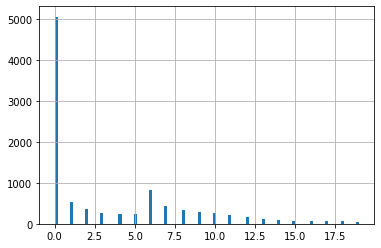

In [180]:
summary_df_final['score'].hist(bins=100) 

In [191]:
print('Out of {} records , {} records have no matches found'.format(summary_df.shape[0] ,summary_df.shape[0]-summary_df_final.shape[0]))

Out of 10000 records , 241 records have no matches found


In [193]:
print('Accuracy: {}'.format((summary_df_final.shape[0])*100/summary_df.shape[0]))

Accuracy: 97.59


## Creating Submission file

In [184]:
mappings = pd.DataFrame()
mappings['P1.key'] = summary_df_final['p1_key']
mappings['P2.key'] = summary_df_final['p2_key']

In [189]:
mappings.to_csv('mappings.csv',index=False)